In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MINIST = True

train_data = torchvision.datasets.MNIST(root='./MNIST_data',train=True,transform=torchvision.transforms.ToTensor(),download=DOWNLOAD_MINIST)

torch.Size([60000, 28, 28])
torch.Size([60000])


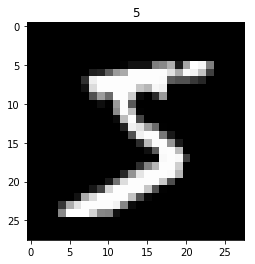

In [3]:
#plot one example
print(train_data.train_data.size()) #(60000,28,28)
print(train_data.train_labels.size())#(60000)
plt.imshow(train_data.train_data[0].numpy(),cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [4]:
train_loader = Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

#pick 2000 sample to speed up testing
test_data = torchvision.datasets.MNIST(root='./MNIST_data/',train=False)
test_x = torch.unsqueeze(test_data.test_data,dim=1).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels[:2000]

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #（1，28，28）维度
        self.conv1 = nn.Sequential(#kernel_size=5 5*5区域扫描,padding=(kernel_size-1)/2
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2,
            ),#output shape（16，28，28）
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,),#-->(16,14,14)
        )
        #out_channels=16,16*pool(2)=32,kernel_size=5,stride=1,padding=2
        #inputshape (16,14,14)
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,5,1,2),#output shape(32,14,14)
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2)#-->(32,7,7)
        )
        #out 32*7*7，10个分类(0-9)
        self.out = nn.Linear(32*7*7,10)
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)#(batch,32,7,7)
        x = x.view(x.size(0),-1)#展平操作  (batch,32,7,7)
        output = self.out(x)
        return output,x

In [6]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(cnn.parameters(),lr=LR)
#parameter
loss_func = nn.CrossEntropyLoss()

In [8]:
from matplotlib import cm
try: 
    from sklearn.manifold import TSNE#TSNE聚类可视化
    HAS_SK = True
except: 
    HAS_SK = False
    print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights,labels):
    plt.cla()
    X, Y = lowDWeights[:,0],lowDWeights[:,1]
    for x,y,s in zip(X,Y,labels):
        c = cm.rainbow(int(255*s/9))
        plt.text(x,y,s,backgroundcolor=c,fontsize=9)
    plt.xlim(X.min(),X.max())
    plt.ylim(Y.min(),Y.max())
    plt.title('Visualize last layer')
    plt.show()
    plt.pause(0.01)
plt.ion()      
        

In [ ]:
for epoch in range(EPOCH):
    #x,y
    for step, (b_x,b_y) in enumerate(train_loader):
        output = cnn(b_x)[0]
        loss = loss_func(output,b_y)    # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        if step % 100 == 0:
            test_output,last_layer = cnn(test_x)
            pred_y = torch.max(test_output,1)[1].data.numpy()#得到预测结果
            #求准确率
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum())/float(test_y.size(0))
            #打印结果
            print('Epoch: ',epoch,'| train loss: %.4f' % loss.data.numpy(),'| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)
                plot_only = 500#
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only,:])##进行数据降维,降成两维
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs,labels)

plt.ioff()

#print 10 predictions from test data
test_output,_ = cnn(test_x[:10])
pred_y = torch.max(test_output,1)[1].data.numpy()
print(pred_y,'prediction number')
print(test_y[:10].numpy(),'real number')  


Epoch:  0 | train loss: 2.3147 | test accuracy: 0.11
